In [7]:
%env DDE_BACKEND=tensorflow
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

env: DDE_BACKEND=tensorflow


In [8]:
rho = 1
mu = 1
u_in = 1
D = 1
L = 2

In [9]:
geom = dde.geometry.Rectangle(xmin=[-L/2, -D/2], xmax=[L/2, D/2])

In [10]:
def boundary_wall(X, on_boundary):
    print("X",X)
    print("on_boundary",on_boundary)
    on_wall = np.logical_and(np.logical_or(np.isclose(X[1],-D/2,rtol=1e-05,atol=1e-08),np.isclose(X[1],D/2,rtol=1e-05,atol=1e-08)),on_boundary)
    return on_wall

def boundary_inlet(X,on_boundary):
    on_inlet = np.logical_and(np.isclose(X[0],-L/2,rtol=1e-05,atol=1e-08),on_boundary)
    return on_inlet

def boundary_outlet(X,on_boundary):
    on_outlet = np.logical_and(np.isclose(X[0],L/2,rtol=1e-05,atol=1e-08),on_boundary)
    return on_outlet

In [11]:
bc_wall_u = dde.DirichletBC(geom, lambda X:0., boundary_wall, component= 0)
bc_wall_v = dde.DirichletBC(geom, lambda X:0., boundary_wall, component= 1)

bc_inlet_u = dde.DirichletBC(geom, lambda X:u_in, boundary_inlet, component= 0)
bc_inlet_v = dde.DirichletBC(geom, lambda X:0.   , boundary_inlet, component= 1)

bc_outlet_p = dde.DirichletBC(geom, lambda X:0.  , boundary_outlet, component= 2)
bc_outlet_v = dde.DirichletBC(geom, lambda X:0.  , boundary_outlet, component= 1)

In [12]:
def pde(X,Y):
    du_x =dde.grad.jacobian(Y, X, i=0, j=0)
    du_y =dde.grad.jacobian(Y, X, i=0, j=1)
    dv_x =dde.grad.jacobian(Y, X, i=1, j=0)
    dv_y =dde.grad.jacobian(Y, X, i=1, j=1)
    dp_x =dde.grad.jacobian(Y, X, i=2, j=0)
    dp_y =dde.grad.jacobian(Y, X, i=2, j=1)
    
    du_xx = dde.grad.hessian(Y, X, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(Y, X, component=0, i=1, j=1)
    dv_xx = dde.grad.hessian(Y, X, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(Y, X, component=1, i=1, j=1)
    
    pde_u    = Y[:,0:1]*du_x +  Y[:,1:2]*du_y + 1/rho * dp_x - (mu/rho) * (du_xx+ du_yy)
    pde_v    = Y[:,0:1]*dv_x +  Y[:,1:2]*dv_y + 1/rho * dp_y - (mu/rho) * (dv_xx+ dv_yy)
    pde_cont = du_x + dv_y
    
    return [pde_u,pde_v,pde_cont]

In [13]:
data = dde.data.PDE(geom,
                   pde,
                   [bc_wall_u,bc_wall_v,bc_inlet_u,bc_inlet_v,bc_outlet_p,bc_outlet_v],
                   num_domain  = 2000,
                   num_boundary= 200,
                   num_test = 200)

X [1.  0.5]
on_boundary True
X [ 0.5 -0.5]
on_boundary True
X [-0.5  0.5]
on_boundary True
X [-0.25 -0.5 ]
on_boundary True
X [0.25 0.5 ]
on_boundary True
X [ 1.   -0.25]
on_boundary True
X [-1.    0.25]
on_boundary True
X [-0.625 -0.5  ]
on_boundary True
X [0.625 0.5  ]
on_boundary True
X [ 0.875 -0.5  ]
on_boundary True
X [-0.875  0.5  ]
on_boundary True
X [ 0.125 -0.5  ]
on_boundary True
X [-0.125  0.5  ]
on_boundary True
X [1.    0.125]
on_boundary True
X [-1.    -0.125]
on_boundary True
X [-0.8125 -0.5   ]
on_boundary True
X [0.8125 0.5   ]
on_boundary True
X [ 0.6875 -0.5   ]
on_boundary True
X [-0.6875  0.5   ]
on_boundary True
X [-0.0625 -0.5   ]
on_boundary True
X [0.0625 0.5   ]
on_boundary True
X [ 1.     -0.0625]
on_boundary True
X [-1.      0.0625]
on_boundary True
X [-0.4375 -0.5   ]
on_boundary True
X [0.4375 0.5   ]
on_boundary True
X [ 1.     -0.4375]
on_boundary True
X [-1.      0.4375]
on_boundary True
X [ 0.3125 -0.5   ]
on_boundary True
X [-0.3125  0.5   ]
on_bound

<function matplotlib.pyplot.show(close=None, block=None)>

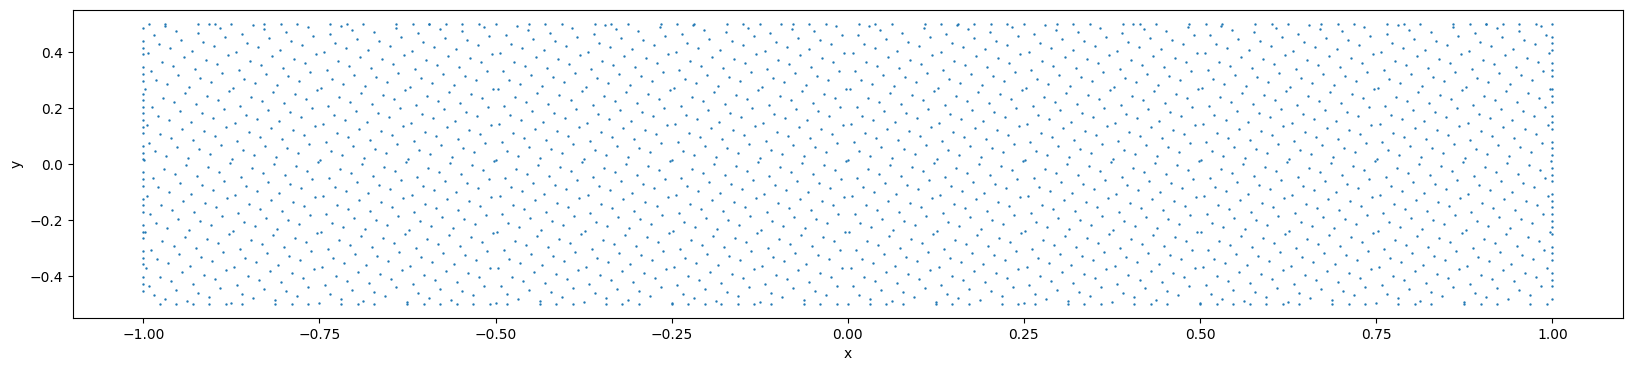

In [14]:
plt.figure(figsize=(20,4))
plt.scatter(data.train_x_all[:,0],data.train_x_all[:,1],s=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.show

In [15]:
net = dde.maps.FNN([2] + [64]*5 + [3] , "tanh", "Glorot uniform")

In [16]:
model = dde.Model(data, net)
model.compile("adam",lr=1e-3)

Compiling model...
'compile' took 0.003615 s



In [17]:
losshistory,train_state = model.train(epochs = 10000, display_every=1000)

Training model...



c:\Users\Matuchaki\AppData\Local\pypoetry\Cache\virtualenvs\deepxde-custom-E_cFIhQu-py3.10\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Cause: could not parse the source code of <function <lambda> at 0x000002660EF451B0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x000002660EF451B0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x000002660EF45510>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x000002660E

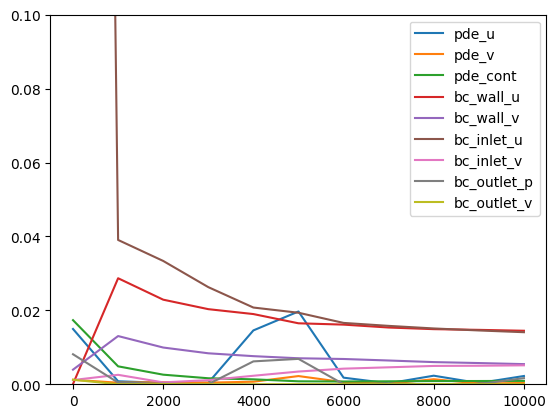

In [18]:

plot_array = np.array(losshistory.loss_test)
plot_labels = ["pde_u", "pde_v", "pde_cont", "bc_wall_u", "bc_wall_v", "bc_inlet_u", "bc_inlet_v", "bc_outlet_p", "bc_outlet_v"]
# plot_array = np.array(losshistory.loss_train)
for i in range(plot_array.shape[1]):
    plt.plot(losshistory.steps, plot_array[:,i], label=plot_labels[i])
    
plt.legend()
plt.ylim([0, 0.1])
plt.show()

In [19]:
dde.optimizers.config.set_LBFGS_options(maxiter = 3000)
model.compile("L-BFGS")
losshistory,train_state = model.train()
dde.saveplot(losshistory, train_state, issave = False , isplot = False)

Compiling model...
'compile' took 0.075967 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
10000     [2.72e-03, 6.33e-04, 2.28e-03, 1.45e-02, 5.46e-03, 1.41e-02, 5.13e-03, 1.66e-03, 1.13e-05]    [2.24e-03, 3.52e-04, 9.17e-04, 1.45e-02, 5.46e-03, 1.41e-02, 5.13e-03, 1.66e-03, 1.13e-05]    []  
13000     [2.95e-04, 3.35e-04, 7.34e-04, 3.04e-03, 7.58e-04, 2.44e-03, 6.72e-04, 1.38e-05, 3.16e-07]    [1.11e-04, 1.97e-04, 2.27e-04, 3.04e-03, 7.58e-04, 2.44e-03, 6.72e-04, 1.38e-05, 3.16e-07]    []  

Best model at step 13000:
  train loss: 8.29e-03
  test loss: 7.46e-03
  test metric: []

'train' took 1325.573183 s



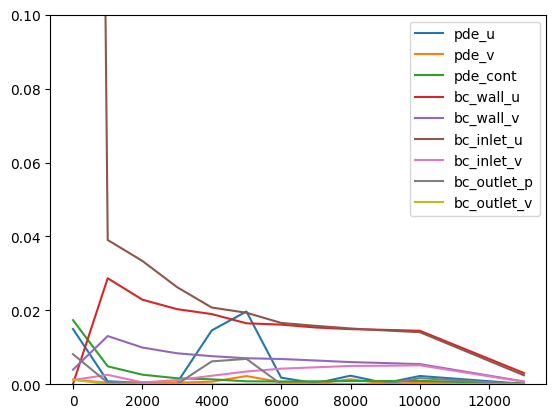

In [20]:
plot_array = np.array(losshistory.loss_test)
plot_labels = ["pde_u", "pde_v", "pde_cont", "bc_wall_u", "bc_wall_v", "bc_inlet_u", "bc_inlet_v", "bc_outlet_p", "bc_outlet_v"]
# plot_array = np.array(losshistory.loss_train)
for i in range(plot_array.shape[1]):
    plt.plot(losshistory.steps, plot_array[:,i], label=plot_labels[i])
    
plt.legend()
plt.ylim([0, 0.1])
plt.show()

In [21]:
samples= geom.random_points(500000)
result = model.predict(samples)

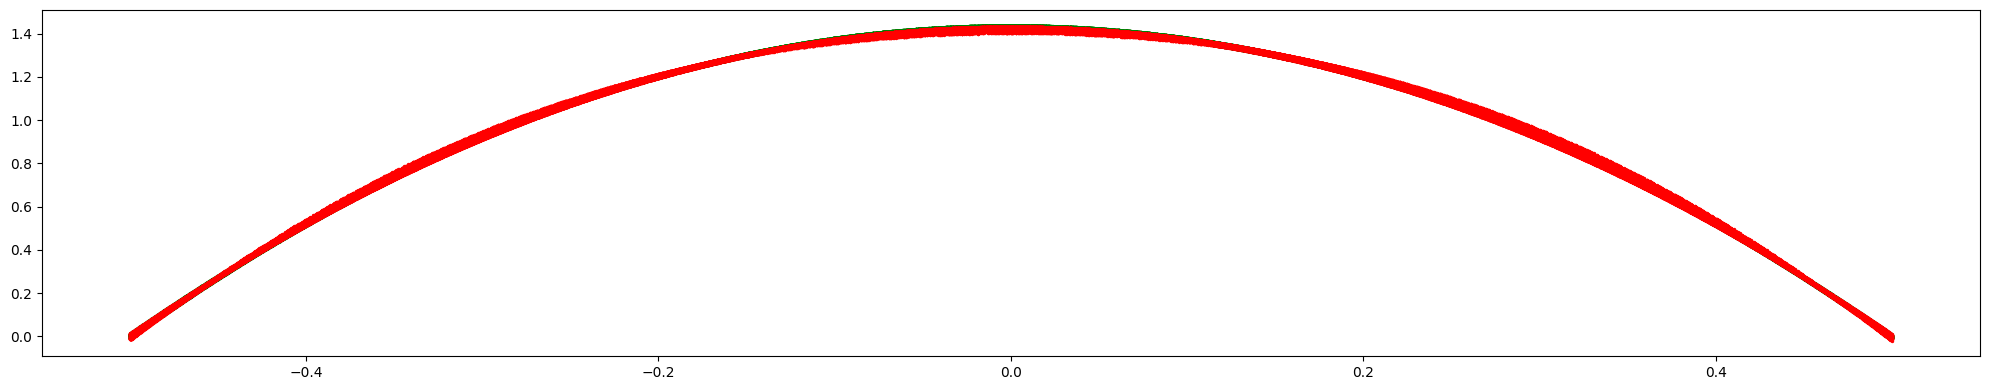

In [22]:
color_legend=[[0,1.5],[-0.3,0.3],[0,35]]
# for idx in range(3):
plt.figure(figsize=(20,4))
mask = np.where((samples[:,0] > (D/2)) & (samples[:,0] < (L/2)))
plt.scatter(samples[mask,1], result[mask,0], c='green',s=2)
mask = np.where((samples[:,0] < -(D/2)) & (samples[:,0] > -(L/2)))
plt.scatter(samples[mask,1], result[mask,0], c='red',s=2)
plt.tight_layout()
plt.show()

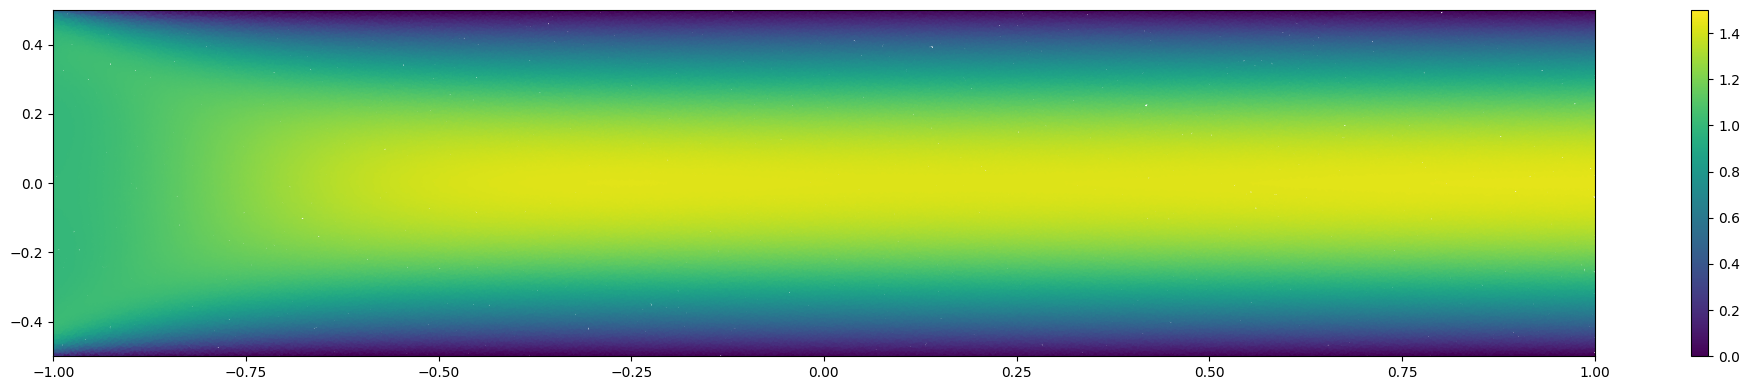

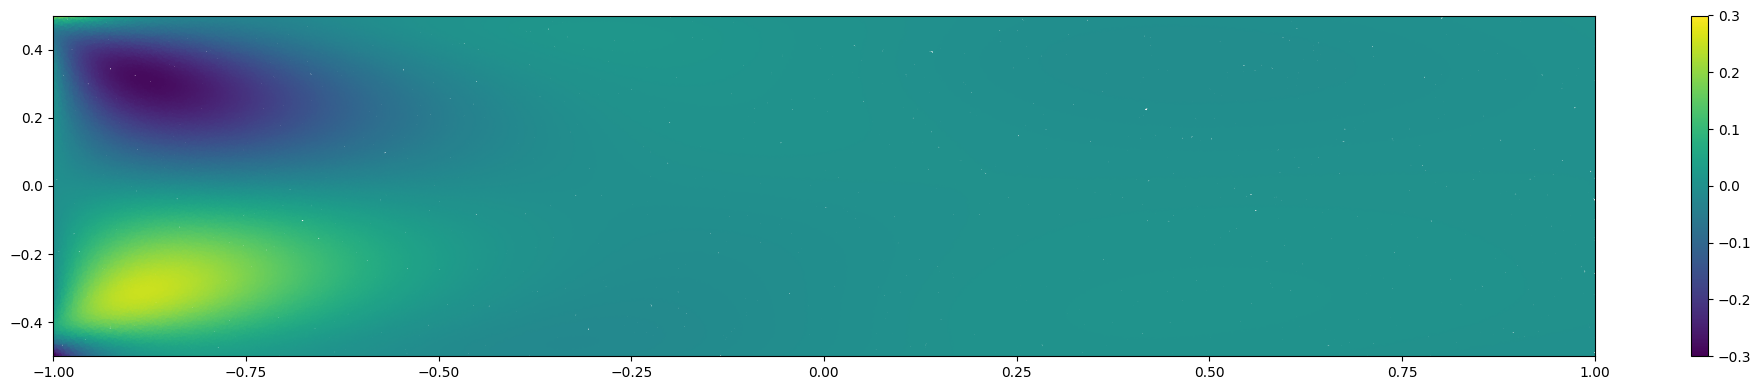

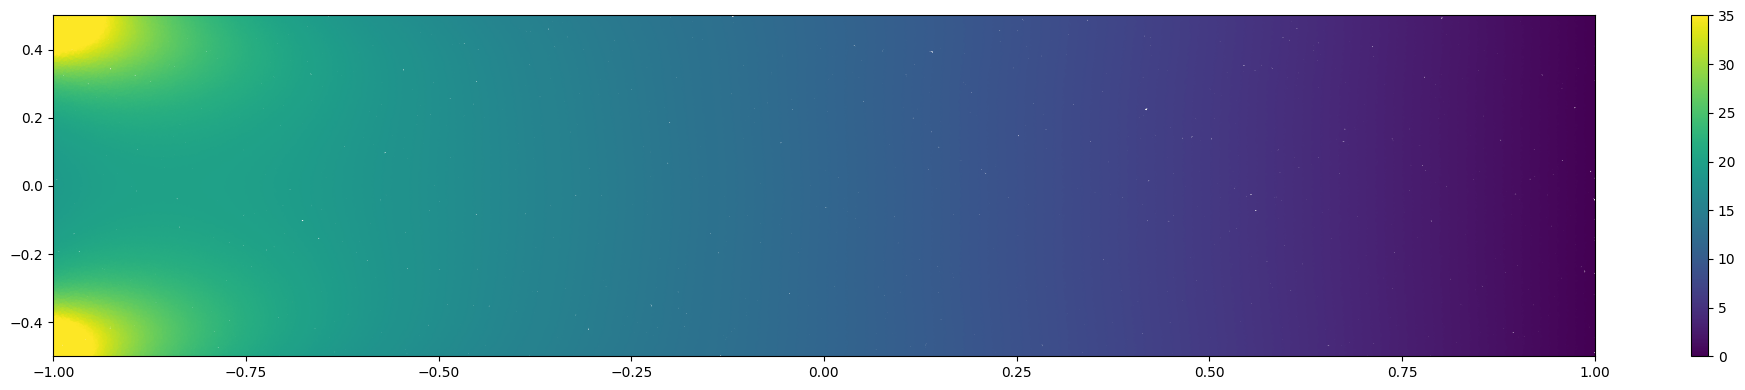

In [23]:
color_legend = [[0,1.5],[-0.3,0.3],[0,35]]

for idx in range(3):
    plt.figure(figsize=(20,4))
    plt.scatter(samples[:,0],
               samples[:,1],
               c = result[:,idx],
               cmap= 'viridis',
               s=2)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((0-L/2, L-L/2))
    plt.ylim((0-D/2, D-D/2))
    plt.tight_layout()
    plt.show()